# HW2: Customer Churn - Kaustubh Jagtap - A0168820B

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from __future__ import division
import seaborn as sns

from sklearn.cross_validation import *
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import chi2


%matplotlib inline
sns.set(color_codes=True)

C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\ksjag\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## EDA

In [3]:
# read in the data as a pandas dataframe
df = pd.read_csv("./customer_churn.csv")

In [4]:
# observe the shape
print(df.shape)

# print the head
df.head()

(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
1,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
2,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
3,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
4,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No


In [5]:
# describe the data
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

### Data Cleaning

In [7]:
# check how many missing data points
# missing data includes " ", None, na values

for col in df:
    count = 0
    for val in df[col]:
        if val == " " or val is None:
            count += 1
    count += df[col].isna().sum()
    print(col + ":", count)

customerID: 0
gender: 0
SeniorCitizen: 0
Partner: 0
Dependents: 0
tenure: 0
PhoneService: 0
MultipleLines: 0
InternetService: 0
OnlineSecurity: 0
OnlineBackup: 0
DeviceProtection: 0
TechSupport: 0
StreamingTV: 0
StreamingMovies: 0
Contract: 0
PaperlessBilling: 0
PaymentMethod: 0
MonthlyCharges: 0
TotalCharges: 11
Churn: 0


In [8]:
## convert all missing data to nan and drop na
df.replace(" ", np.nan, inplace=True)
df.dropna(inplace=True)

In [9]:
# drop customer ID
df.drop("customerID", axis=1, inplace=True)

# convert strings to floats
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"])

### Understand the columns through analysis & visualization

#### Churn Rate

In [10]:
df["Churn"].value_counts()

No     5163
Yes    1869
Name: Churn, dtype: int64

#### Categorical Columns

- Determine how significant the columns are by observing how they affect the churn

GENDER:
Male      3549
Female    3483
Name: gender, dtype: int64
 


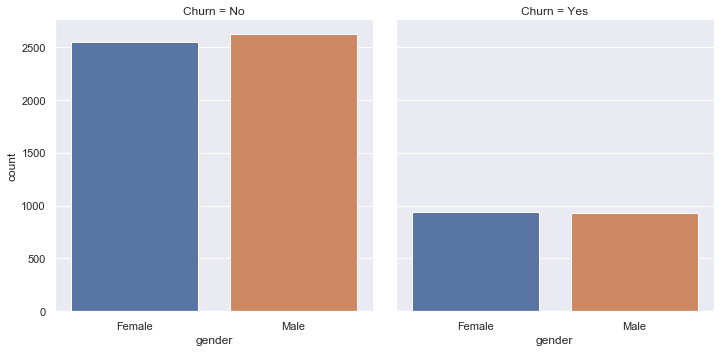

 
PARTNER:
No     3639
Yes    3393
Name: Partner, dtype: int64
 


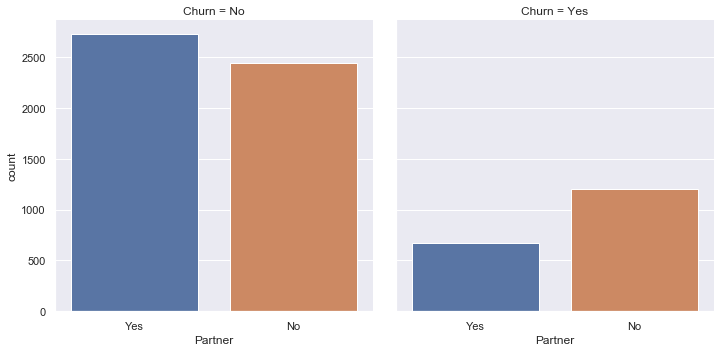

 
DEPENDENTS:
No     4933
Yes    2099
Name: Dependents, dtype: int64
 


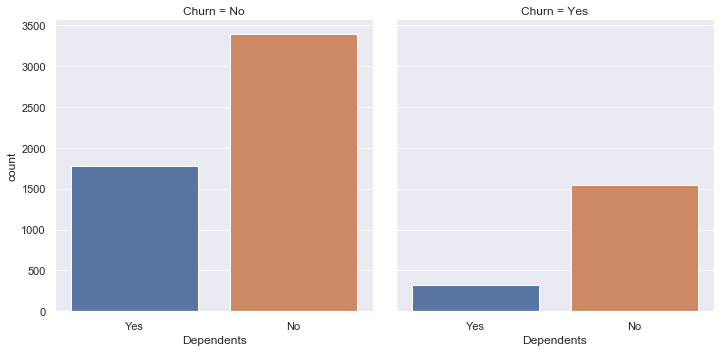

 
PHONESERVICE:
Yes    6352
No      680
Name: PhoneService, dtype: int64
 


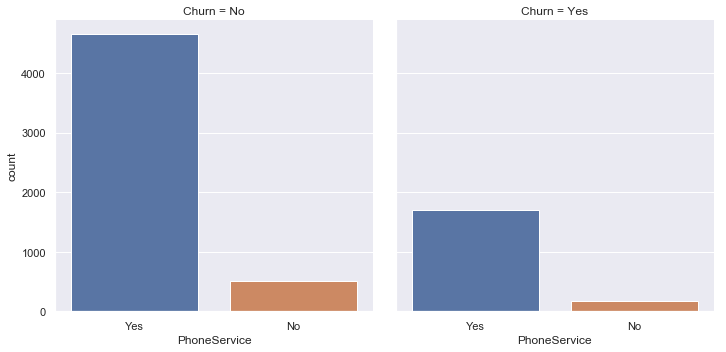

 
MULTIPLELINES:
No                  3385
Yes                 2967
No phone service     680
Name: MultipleLines, dtype: int64
 


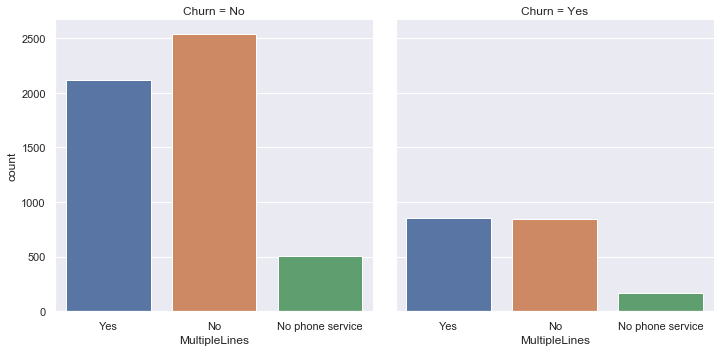

 
INTERNETSERVICE:
Fiber optic    3096
DSL            2416
No             1520
Name: InternetService, dtype: int64
 


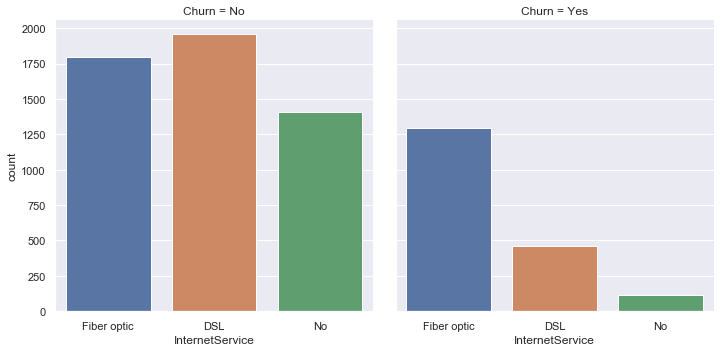

 
ONLINESECURITY:
No                     3497
Yes                    2015
No internet service    1520
Name: OnlineSecurity, dtype: int64
 


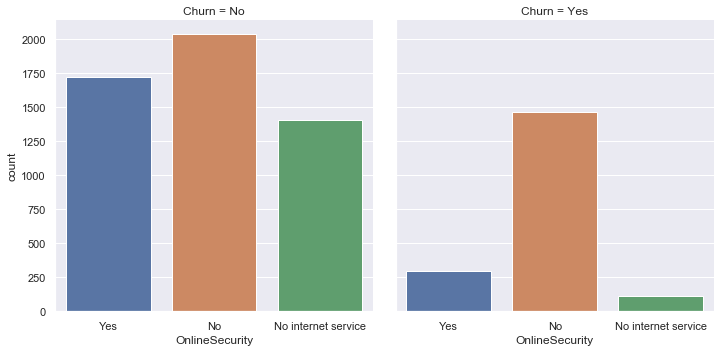

 
ONLINEBACKUP:
No                     3087
Yes                    2425
No internet service    1520
Name: OnlineBackup, dtype: int64
 


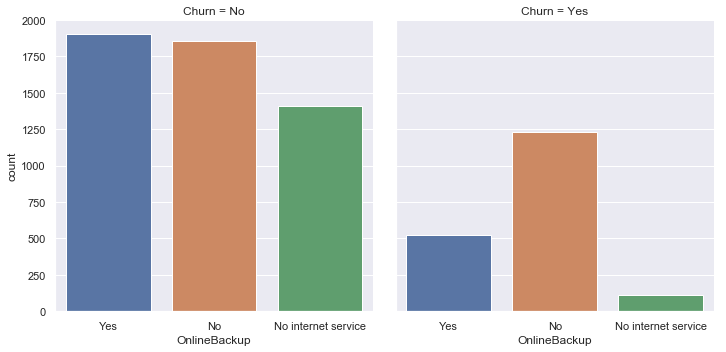

 
DEVICEPROTECTION:
No                     3094
Yes                    2418
No internet service    1520
Name: DeviceProtection, dtype: int64
 


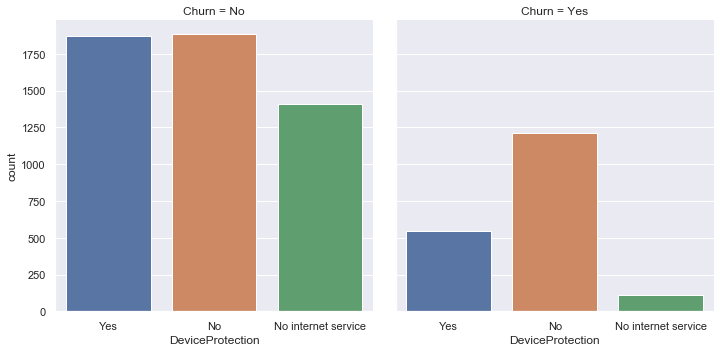

 
TECHSUPPORT:
No                     3472
Yes                    2040
No internet service    1520
Name: TechSupport, dtype: int64
 


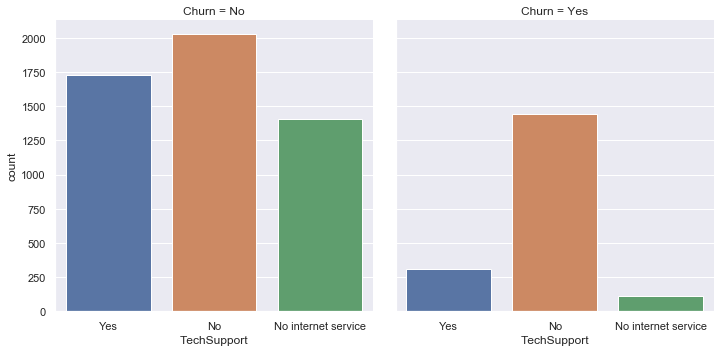

 
STREAMINGTV:
No                     2809
Yes                    2703
No internet service    1520
Name: StreamingTV, dtype: int64
 


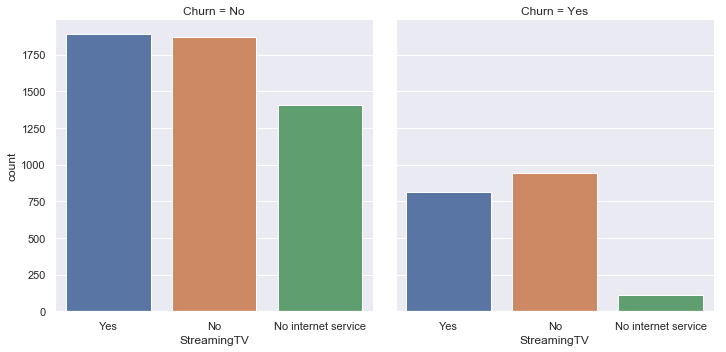

 
STREAMINGMOVIES:
No                     2781
Yes                    2731
No internet service    1520
Name: StreamingMovies, dtype: int64
 


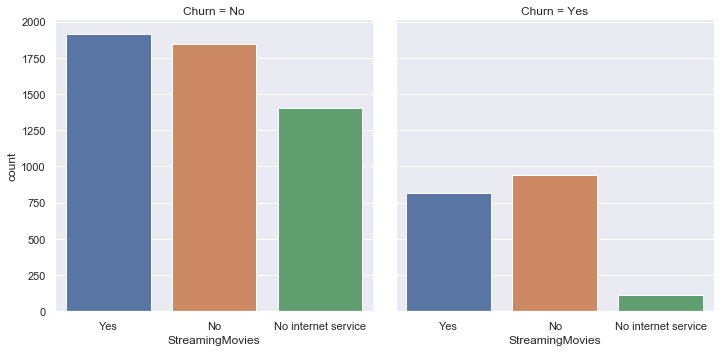

 
CONTRACT:
Month-to-month    3875
Two year          1685
One year          1472
Name: Contract, dtype: int64
 


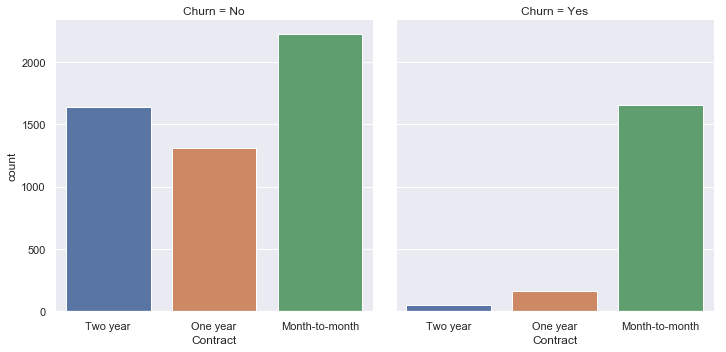

 
PAPERLESSBILLING:
Yes    4168
No     2864
Name: PaperlessBilling, dtype: int64
 


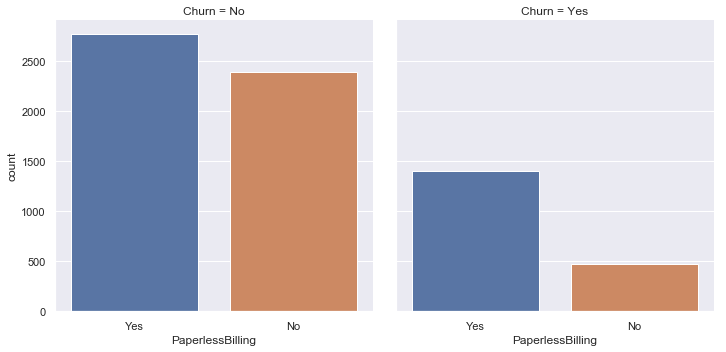

 
PAYMENTMETHOD:
Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64
 


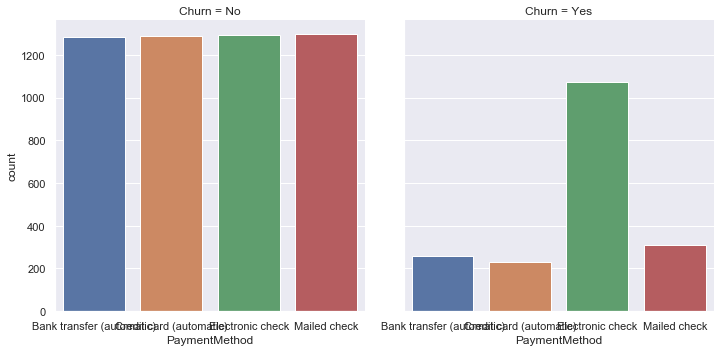

In [22]:
for col_name in df.iloc[:, :19]:
    if df[col_name].dtype == "object":
        print('\033[1m' + col_name.upper() + ":" + '\033[0m')
        print(df[col_name].value_counts())
        print(" ")
        
        sns.catplot(x=col_name, col="Churn", data=df, kind='count')
        plt.show()
        print(" ")

##### Observation

- From the above visualisations, we can tell the ratio of churn to no churn is very similar for both groups of the `gender` variable. Hence, we can infer that `gender` is not a significant variable

#### Continuous Variables

- Monthly Charges, Total Charges and Tenure

TENURE:
count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64


C:\Users\ksjag\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


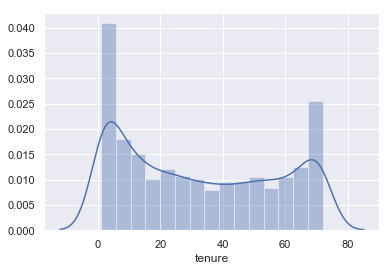

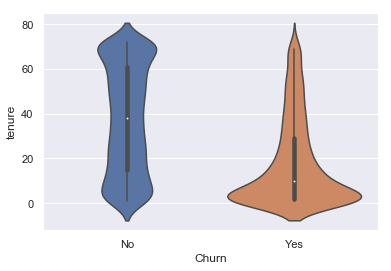

MONTHLYCHARGES:
count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64


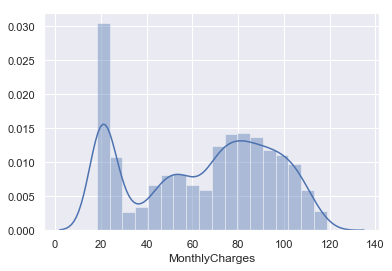

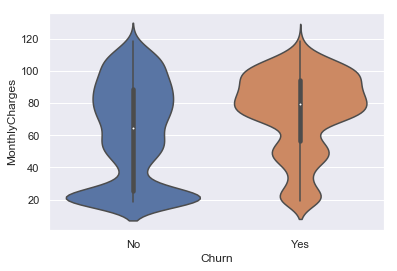

TOTALCHARGES:
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64


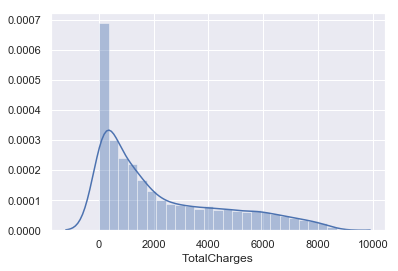

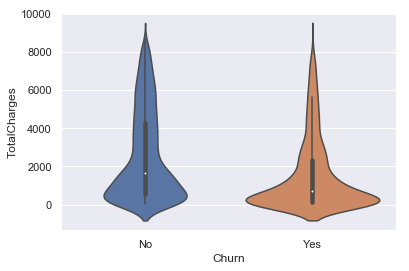

In [12]:
for col_name in df.iloc[:, :19]:
    if col_name in ("MonthlyCharges", "tenure", "TotalCharges"):
        print('\033[1m' + col_name.upper() + ":" + '\033[0m')

        print(df[col_name].describe())

        sns.distplot(df[col_name])
        plt.show()

        sns.violinplot(x="Churn", y=col_name, data=df)
        plt.show()

##### Observation

- Tenure: Churn is high when the tenure is still low. For this customer group, they may be still deciding on their preferred telco and once they cross the 18-month (1.5 years) barrier, they tend to stick with the telco for a long time horizon

- Monthly Charges: Higher monthly charge customers have higher churn than lower ones. These may be more well-off customers who are willing to pay more, but demand better service and are easily dissatisfied

- Total Charges: There are too many people with total charges lower than 2000, and it is hard to tell from the above violin plot if there is any correlation between total charges and churn

## Data Preparation

In [13]:
## drop the customerID and the labels
features = df.iloc[:, :19]

## isolate the classes/ labels
labels = (df["Churn"] == "Yes").astype(int)

In [14]:
# isolate the continuous features
cts_features = features[["tenure","MonthlyCharges", "TotalCharges"]]  
features.drop(cts_features, axis=1, inplace=True)

features.head()
features = pd.get_dummies(features)

In [15]:
features.head()

,SeniorCitizen,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
11,0,1,0,0,1,0,1,0,1,0,...,1,0,0,1,0,1,1,0,0,0
12,0,1,0,0,1,0,1,0,1,0,...,1,0,0,1,1,0,0,1,0,0
13,0,0,1,0,1,1,0,0,1,0,...,1,0,0,1,0,1,0,1,0,0
14,0,0,1,0,1,1,0,0,1,0,...,1,0,0,1,0,1,0,0,1,0
15,0,0,1,1,0,1,0,0,1,0,...,1,0,0,1,0,1,0,0,1,0


#### Discretise Monthly Charges

In [16]:
# # define the bins
# bins = [0, 20, 40, 60, 80, 100, 120]

# # cut the series into bins
# monthly_charges_binned = pd.cut(cts_features["MonthlyCharges"], bins)
# print(monthly_charges_binned.value_counts())

# # convert series to dataframe and name the column
# monthly_charges_binned = monthly_charges_binned.to_frame()
# monthly_charges_binned.columns = ['monthly_charges_range']

#### Discretise Total Charges
Note - Total charges are stored as strings and there are some blank values

In [17]:
# ## binning by value
# # define the bins
# bins = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000]

# # cut the series into bins
# total_charges_binned = pd.cut(cts_features["TotalCharges"], bins)
# print(total_charges_binned.value_counts())

# # convert the series to dataframe and name the column
# total_charges_binned = total_charges_binned.to_frame()
# total_charges_binned.columns = ['total_charges_range']

#### Discretize Tenure

In [18]:
# ## binning by value

# # define the bins
# bins = [0, 12, 24, 36, 48, 60, 72]

# # cut the series into bins
# tenure_binned = pd.cut(cts_features["tenure"], bins)
# print(tenure_binned.value_counts())

# # convert the series to dataframe and name the column
# tenure_binned = tenure_binned.to_frame()
# tenure_binned.columns = ['tenure_range']

#### Join back the dataframe

- We will end up with 2 dataframes for the features: one with binned discretized data and one with grouped discretized data

In [19]:
# join with main dataframe to get all features
features = features.join(cts_features)
features.head()

,SeniorCitizen,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,...,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
11,0,1,0,0,1,0,1,0,1,0,...,1,0,1,1,0,0,0,72,118.75,8672.45
12,0,1,0,0,1,0,1,0,1,0,...,1,1,0,0,1,0,0,72,117.50,8670.10
13,0,0,1,0,1,1,0,0,1,0,...,1,0,1,0,1,0,0,72,116.95,8594.40
14,0,0,1,0,1,1,0,0,1,0,...,1,0,1,0,0,1,0,71,116.25,8564.75
15,0,0,1,1,0,1,0,0,1,0,...,1,0,1,0,0,1,0,72,118.20,8547.15


## Model Building

We will try the following models in this section:
- logistic regression
- bagging
- random forest
- boosting

### Determine significant features

We have already observed from the visualisation section that `gender` is not a significant feature. There may be other insignificant features, and it would benefit us to determine these statsitically.

In [20]:
# calculate p-values to check for significance of all features
p_values = chi2(features, labels)[1]

# iterate over p-values and check if meets 95% confidence level
for col_num, value in enumerate(p_values):
    if value > 0.05:
        colname = features.columns[col_num]
        print(colname, value)

gender_Female 0.6107282754601306
gender_Male 0.6140655052865054
PhoneService_No 0.3514409861316786
PhoneService_Yes 0.7604618273699781
MultipleLines_No phone service 0.3514409861316786


##### Observation
From the above p-values, we can clearly tell that gender and phone service should be dropped from the dataframe. We shall proceed to drop them below.

In [21]:
## drop insignificant features from features_binned
features.drop(['gender_Female', 'gender_Male', 'PhoneService_No', 'PhoneService_Yes'], inplace=True, axis=1)

### Train-Test Split
We will do a 70-30 split

In [273]:
X_train, X_test, Y_train, Y_test = 

In [277]:
len(test[1])

1758